# Noções de IA - Trabalho 2 - Perceptron Multicamada no problema MNIST
##### Integrantes:
- Lucas Corrêa Boaventura           - 211038262
- Alexandre Castanho Sampaio Rocha  - 211027536

### Bibliotecas

In [118]:
import tensorflow as tf
from d2l import tensorflow as d2l
d2l.use_svg_display()
from random import randint 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Banco de Dados MNIST

In [119]:
class MNIST(d2l.DataModule): #@save
    """The MNIST dataset."""
    def __init__(self, batch_size=64):
        super().__init__()
        self.save_hyperparameters()
        self.train, self.val = tf.keras.datasets.mnist.load_data()

In [120]:
data = MNIST()
print(len(data.train[0]), len(data.val[0]))
print(data.train[0].shape)

60000 10000
(60000, 28, 28)


In [121]:
@d2l.add_to_class(MNIST) #@save
def get_dataloader(self, train:bool):
    data = self.train if train else self.val
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255, tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (tf.image.resize_with_pad(X, *self.resize), y)
    shuffle_buf = len(data[0]) if train else 1
    return tf.data.Dataset.from_tensor_slices(process(*data)).batch(self.batch_size).shuffle(shuffle_buf)

In [122]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

(64, 28, 28, 1) <dtype: 'float32'> (64,) <dtype: 'int32'>


### Classe de Perpectron Multi Camada

In [123]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, lr, num_hid_layers, num_neurons, hidden_actv, output_actv, loss_fn, optimizer):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            *[tf.keras.layers.Dense(num_neurons, activation=hidden_actv) for _ in range(num_hid_layers)],
            tf.keras.layers.Dense(num_outputs, activation=output_actv)
        ])

### Função para mostrar acurácia média de n redes

In [124]:
def show_avg_acc(model_params,max_epochs=15,num_trainings=1):
    test_acc_avg = 0
    for _ in range(num_trainings):
        data = MNIST()
        model = MLP(*model_params)
        trainer = d2l.Trainer(max_epochs)
        trainer.fit(model, data)
        test_acc_avg += d2l.evaluate_accuracy(model, data.val_dataloader())
    print(f'Acurácia média de {num_trainings} redes: {test_acc_avg*(100/num_trainings):.2f}%')
    return model

## Treinamentos com parâmetros variados 

#### A)
- 1 Camada Escondida de 128 neurônios
- Camada escondida com ativação Sigmoid
- Saída com ativação Sigmoid
- Custo como Erro Médio Quadrático (MSE)
- Otimizador Descida de Gradiente (SGD) 

Acurácia média de 1 redes: 91.30%


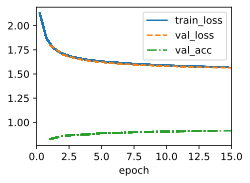

In [125]:
model_params = [10,                                     #num_outputs
                0.1,                                    #lr
                1,                                      #num_hid_layers
                128,                                    #num_neurons
                'sigmoid',                              #hidden_actv
                'sigmoid',                              #output_actv
                tf.keras.losses.MeanSquaredError(),     #loss_fn
                tf.keras.optimizers.SGD()               #optimizer
        ]             
model = show_avg_acc(model_params)

#### Avaliação
    Apresentou uma boa acurácia apesar da utilização de funções clássicas.

#### B)
- 1 Camada Escondida de 128 neurônios
- Camada escondida com ativação Sigmoid
- Saída com ativação <font color=yellow>*Softmax*</font>
- Custo <font color=yellow>*Entropia Cruzada (SCCE)*</font>
- Otimizador Descida de Gradiente (SGD)

Acurácia média de 1 redes: 76.72%


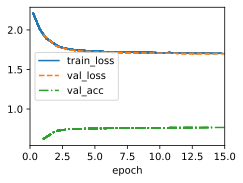

In [126]:
model_params = [10,
                0.1,
                1,
                128,
                'sigmoid',
                'softmax',
                tf.keras.losses.SparseCategoricalCrossentropy(), 
                tf.keras.optimizers.SGD(),
            ]
model = show_avg_acc(model_params)

#### Avaliação
    *Apresentou uma perda média da acurácia, possivelmente devido a magia negra.

#### C)
- 1 Camada Escondida de 128 neurônios
- Camada escondida com ativação Sigmoid
- Saída com ativação Softmax
- Custo Entropia Cruzada (SCCE)
- Otimizador <font color=yellow>*Adam*</font>

Acurácia média de 1 redes: 91.92%


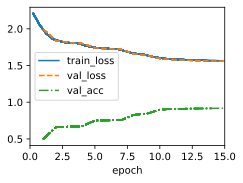

In [127]:
model_params = [10,
            0.1,
            1,
            128,
            'sigmoid',
            'softmax',
            tf.keras.losses.SparseCategoricalCrossentropy(),
            tf.keras.optimizers.Adam(),
]
model = show_avg_acc(model_params)

#### Avaliação
    Apresentou uma melhora pequena na média da acurácia, já que o otimizador Adam permite uma aproveitamento do embalo de aprendizagem.

#### D)
- 1 Camada Escondida de 128 neurônios
- Camada escondida com ativação <font color=yellow>*Relu*</font>
- Saída com ativação Softmax
- Custo Entropia Cruzada (SCCE)
- Otimizador Adam

Acurácia média de 1 redes: 95.21%


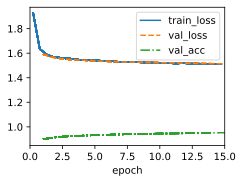

In [128]:
model_params = [10,
            0.1,
            1,
            128,
            'relu',
            'softmax',
            tf.keras.losses.SparseCategoricalCrossentropy(),
            tf.keras.optimizers.Adam(),
]
model = show_avg_acc(model_params)

#### Avaliação
    Apresentou uma ótima melhora na média da acurácia, já que ativação relu é a mais utilizada para as camadas escondidas pela seu histórico de ser melhor.

#### E)
- 1 Camada Escondida de <font color=yellow>*256*</font> neurônios
- Camada escondida com ativação Relu
- Saída com ativação Softmax
- Custo Entropia Cruzada (SCCE)
- Otimizador Adam

Acurácia média de 1 redes: 95.67%


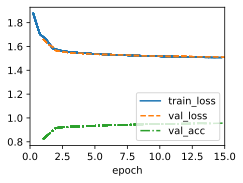

In [129]:
model_params = [10,
                0.1,
                1,
                256,
                'relu',
                'softmax',
                tf.keras.losses.SparseCategoricalCrossentropy(),
                tf.keras.optimizers.Adam(),
]
model = show_avg_acc(model_params)

#### Avaliação
    Apresentou uma melhora pequena na média da acurácia, mas, como estamos acima de 90%, até 1% é uma mudança significativa. Essa melhora é por usarmos uma rede mais robusta com mais neurônios.

#### F)
- <font color=yellow>*2*</font> Camadas Escondidas de 256 neurônios
- Camada escondida com ativação Relu
- Saída com ativação Softmax
- Custo Entropia Cruzada (SCCE)
- Otimizador Adam 

Acurácia média de 1 redes: 97.01%


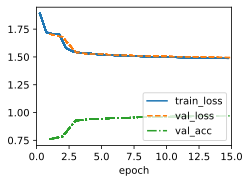

In [130]:
model_params = [10,
                0.1,
                2,
                256,
                'relu',
                'softmax',
                tf.keras.losses.SparseCategoricalCrossentropy(),
                tf.keras.optimizers.Adam(),
]
model = show_avg_acc(model_params)

#### Avaliação
    Apresentou uma melhora ainda mais significativa acima dos 90% na média da acurácia. Essa melhora mostra que uma rede mais profunda resolve melhor o nosso problema. Assim, essa rede será a escolhida e analisada mais a fundo abaixo.

## Visualização
Abaixo segue alguns exemplo classificados de maneira incorreta.
Para cada imagem, temos um par ordenado por (Valor esperado, Valor classificado).


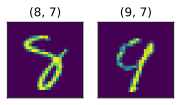

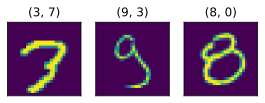

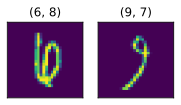

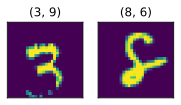

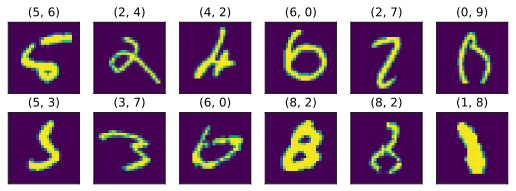

In [131]:
i = 5
allwrongs = [[],[],[]]
for X_batch, y_batch in data.val_dataloader():
    preds=tf.argmax(model(X_batch),axis=1,output_type = tf.int32)
    wrong=preds!=y_batch
    X_wrongs,y_wrongs,preds_wrongs=X_batch[wrong],y_batch[wrong],preds[wrong]
    allwrongs[0].extend(X_wrongs),allwrongs[1].extend(y_wrongs),allwrongs[2].extend(preds_wrongs)
    if len(X_wrongs) > 1:
        if randint(1,20) == 2:
            d2l.show_images(tf.squeeze(X_wrongs), 1, len(X_wrongs),titles=[(int(y),int(pred)) for (y,pred) in zip(y_wrongs[:len(X_wrongs)],preds_wrongs[:len(X_wrongs)])])
            i-=1
            if i == 0 : break

d2l.show_images(tf.squeeze(allwrongs[0]), 2, 6,titles=[(int(y),int(pred)) for (y,pred) in zip(allwrongs[1][:12],allwrongs[2][:12])]);plt.show()

#### Análise
    Olhando esses erros gerados em algums ciclos de treinamento, percebe-se que algums exemplos poderiam ser incorretamente classificados inclusive por seres humanos.
    Porém, ainda há erros que humanos dificilmente cometeriam.

## Matriz de Confusão

In [132]:
num_labels=[f'nº {i}' for i in range(10)]

mini_batch_confusion_matrix=confusion_matrix(y,preds,labels=[i for i in range(10)])
mini_batch_confusion_matrix-=confusion_matrix(y,preds,labels=[i for i in range(10)])

for X, y in data.val_dataloader():
    preds=tf.argmax(model(X),axis=1)
    mini_batch_confusion_matrix += confusion_matrix(y,preds,labels=[i for i in range(10)])

ConfusionMatrixDisplay(confusion_matrix=mini_batch_confusion_matrix,display_labels=num_labels).plot(colorbar=0)
plt.show()



ValueError: Found input variables with inconsistent numbers of samples: [64, 16]

## Análise
    Observando a matriz de confusão acima, pode-se notar que as confusões mais comuns e suas relativas semelhanças são entre:
- 4 com 9 => topo arredondado
- 7 com 2 => reta relativamente horizontal na parte superior
- 5 com 3 => semi-circulo na parte inferior
- 3 com 8 => não vejo

    Desse erros, conseguimos perceber certos padrões para justificar os erros. Porém a 4ª confusão não faz sentido.  